In [ ]:
import pandas as pd
import numpy as np
import re
import requests
import time

from bs4 import BeautifulSoup

def moveSibling(tag, number):
	i = 1
	while i <= number:
		tag = tag.nextSibling
		i += 1
	return tag

from matplotlib import pyplot as plt
%matplotlib inline

In [412]:
# Set up dfs for download

columns_dl = 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A'
downloaded_df = pd.DataFrame(data=None, columns=columns_dl)

try:
    for year in range(2006, 2017):
        y1 = str(year)[2:]
        y2 = str(year+1)[2:]
        url = "http://www.football-data.co.uk/mmz4281/" + y1 + y2 + "/D1.csv"
        df = pd.read_csv(url)
        df = df.loc[:, columns_dl]
        downloaded_df = downloaded_df.append(df)
        
        seasonlist = [2006 + i/(9*34) for i in range(len(downloaded_df))]
        gamedaylist = [1 + np.mod(i/9,34) for i in range(len(downloaded_df))]
        
        downloaded_df.loc[:, "Season"] = seasonlist
        downloaded_df.loc[:, "Gameday"] = gamedaylist
        
        teamlist = downloaded_df.loc[:, "HomeTeam"].unique()
        data = np.array([range(len(teamlist)), teamlist]).T
        team_df = pd.DataFrame(data=data, columns=['TID', 'TName'])
        
    downloaded_df.index = range(len(downloaded_df))
    downloaded_df.to_csv('Downloaded_Raw_2006_2016.csv')
    print "Download successful."
except:
    print "Download failed. Try and proceed without."
    try: 
        team_df = pd.read_csv("Team_ID_hardcoded.csv")
        team_df = team_df.loc[:, ["TID", "TName"]]
    except:
        print "Team_DF error"

        
try:
    cleaned_df = pd.merge(team_df, downloaded_df, how='inner', left_on='TName', right_on='HomeTeam')
    cleaned_df = pd.merge(team_df, cleaned_df, how='inner', left_on='TName', right_on='AwayTeam', suffixes=('_A', '_H'))

    columns_cl = ['Season', 'Gameday', 'TID_H', 'TID_A', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A']
    cleaned_df = cleaned_df.loc[:, columns_cl].sort_values(['Season', 'Gameday'])
    cleaned_df.index = range(len(cleaned_df))

    cleaned_df.to_csv('Bundesliga_Data_2006_2016.csv', index=False)
    print "Merge successful."

except:
    cleaned_df = pd.read_csv('Bundesliga_Data_2006_2016.csv', index_col=0)
    print "Import successful."


    
if team_df.index.name != 'TID':
    team_df = team_df.set_index('TID')

Download successful.
Merge successful.


In [ ]:
# Read files from kicker database
try:
    matches_df = pd.read_csv("Matches_2006_2016.csv", index_col=0)
except:
    print "Error reading matches"
try:
    goals_df = pd.read_csv("Goals_2006_2016.csv", index_col=0)
except:
    print "Error reading goals"
try:
    lineup_df = pd.read_csv("Lineup_2006_2016.csv", index_col=0)
except:
    print "Error reading lineups"

In [415]:
try:
    key_df = pd.read_csv('Team_ID_hardcoded.csv')
    print "Import Successful"
except:
    team_list = []
    for year in range(2005,2017):
        url = 'http://www.kicker.de/news/fussball/bundesliga/vereine/1-bundesliga/'
        url += str(year) + '-' + str(year+1)[-2:]
        url += '/vereine-liste.html'

        website = requests.get(url)
        main = BeautifulSoup(website.content, 'html.parser')
        for team in main.find_all('a', {'class': 'link verinsLinkBild'}):
            team_name_id = team.get('href').split('/')[7]
            team_name = team_name_id[0:team_name_id.rfind("-")]
            team_id = team_name_id[team_name_id.rfind("-")+1:]
            team_list += [[int(team_id), team_name]]
            
    kicker_team_df = pd.DataFrame(data=team_list, columns=['KID', 'KName'])
    kicker_team_df = kicker_team_df.drop_duplicates().set_index('KID')
    
    print "Manual hard-coding of IDs necessary."
    # Then manually hardcode matching IDs

Import Successful


In [479]:
kicker_grades_df = \
pd.concat([matches_df.loc[:, ['Season', 'Gameday', 'TeamH', 'HGA']].rename(columns={'TeamH': 'KID', 'HGA': 'GradeAvg'}),
           matches_df.loc[:, ['Season', 'Gameday', 'TeamA', 'AGA']].rename(columns={'TeamA': 'KID', 'AGA': 'GradeAvg'})])

kicker_grades_df.to_csv('Grades_2006_2016.csv')

In [480]:
kicker_grades_df = pd.read_csv('Grades_2006_2016.csv')

def rescale_grade(x):
    return 1 - (x-1.)/5

grades_df = kicker_grades_df.merge(key_df, how='left', left_on='KID', right_on='KID').loc[:, ('Season', 'Gameday','TID', 'GradeAvg')]
grades_df = grades_df.set_index(['TID', 'Season', 'Gameday']).sort_index()
grades_df = grades_df.apply(rescale_grade)


pd.merge(
    kicker_grades_df.loc[:, ['KID', 'GradeAvg']].groupby('KID').mean(),
    key_df.loc[:, ['KID', 'TName']], 
    how='inner', left_index=True, right_on='KID').loc[:, ['TName', 'GradeAvg']].sort_values('GradeAvg').head()

,TName,GradeAvg
33,RB Leipzig,2.990260
0,Bayern Munich,3.218580
12,Dortmund,3.322676
2,Leverkusen,3.381947
32,Ingolstadt,3.515152


In [481]:
def inverse(x):
    return 1./x
def points(x):
    if x > 0:
        return 3
    elif x == 0:
        return 1
    else:
        return 0

In [615]:
complete_df = cleaned_df.merge(grades_df, how='inner', left_on=['TID_H', 'Season', 'Gameday'], right_index=True)
complete_df = complete_df.merge(grades_df, how='inner', left_on=['TID_A', 'Season', 'Gameday'], right_index=True)

complete_df = complete_df.rename(columns={'GradeAvg_x': 'HGA', 'GradeAvg_y': 'AGA'})
try:
    complete_df = complete_df.replace({'H':1, 'D':0.5, 'A':0})
except:
    print "Replace Problem"
complete_df.loc[:, 'FTGD'] = complete_df.loc[:, 'FTHG'] - complete_df.loc[:, 'FTAG']
complete_df.loc[:, 'HTGD'] = complete_df.loc[:, 'HTHG'] - complete_df.loc[:, 'HTAG']

try:
    complete_df.loc[:, 'Odds'] = (complete_df.filter(regex='^B365').apply(inverse)*(1,0.5,0)).apply(np.sum, axis=1)
except:
    complete_df.loc[:, 'Odds'] = np.nan

complete_df = complete_df.filter(regex='^(?!B365)')
complete_df = complete_df.drop(['FTAG', 'FTR', 'HTAG', 'HTR'], axis=1)

In [669]:
try:
    complete_df = complete_df.drop('Gameday', axis=1)
except:
    pass

make_int_columns = [u'Attendance', u'ChancesA', u'ChancesH', u'CornersA', u'CornersH', 
                    u'Gameday', u'GoalsA', u'GoalsH', u'Link', u'Season', u'TID_H', u'TID_A']

for col in make_int_columns:
    kicker_merged_df.loc[:, col] = kicker_merged_df.loc[:, col].astype(int)
    
all_merged_df = pd.merge(complete_df, kicker_merged_df.drop(['HGA', 'AGA', 'TeamH', 'TeamA', 'GoalsH', 'GoalsA'], axis=1), how='left', left_on=['Season', 'TID_H', 'TID_A'], right_on=['Season', 'TID_H', 'TID_A'])

In [748]:
multi_index = pd.MultiIndex(levels=[[],[],[]],
                             labels=[[],[],[]],
                             names=[u'TID', u'Season', u'Gameday'])
running_df = pd.DataFrame(data=None, columns=['Points'], index=multi_index)

for tid in range(len(key_df)):
    query = 'TID_H == ' + str(tid)
    temp_H = all_merged_df.query(query).loc[:, ['TID_H', 'Season', 'Gameday', 'FTGD']]
    temp_H.loc[:, 'Gameday'] += 1
    temp_H.loc[:, 'GD'] = temp_H.loc[:, 'FTGD']
    temp_H.drop('FTGD', axis=1)
    temp_H = temp_H.set_index(['TID_H', 'Season', 'Gameday'])

    query = 'TID_A == ' + str(tid)
    temp_A = all_merged_df.query(query).loc[:, ['TID_A', 'Season', 'Gameday', 'FTGD']]
    temp_A.loc[:, 'Gameday'] += 1
    temp_A.loc[:, 'GD'] = -1 * temp_A.loc[:, 'FTGD']
    temp_A.drop('FTGD', axis=1)
    temp_A = temp_A.set_index(['TID_A', 'Season', 'Gameday'])

    temp = pd.concat([temp_H, temp_A]).sort_index()
    temp.index = temp.index.rename(['TID', 'Season', 'Gameday'])
    temp = temp.loc[:, 'GD'].apply(points).rename('Points').to_frame()
    
    running_df = running_df.append(temp.groupby(level=['TID', 'Season'], group_keys=False).rolling(3, 1).mean()).apply(np.round, args=(3,))

running_df.to_csv('Running_Points_2006_2016.csv')

In [761]:
complete_running_df = all_merged_df.merge(running_df, how='left', left_on=['TID_H', 'Season', 'Gameday'], right_index=True)
complete_running_df = complete_running_df.merge(running_df, how='left', left_on=['TID_A', 'Season', 'Gameday'], right_index=True)

complete_running_df = complete_running_df.rename(columns={'Points_x': 'HP3', 'Points_y': 'AP3'})
complete_running_df = complete_running_df.sort_values(['Season', 'Gameday', 'TID_H'])

columns_cr = [u'Season', u'Gameday', u'TID_H', u'TID_A', u'TName_H', u'TName_A', u'FTGD', u'HTGD', u'FTHG', u'HTHG', 
              u'HGA', u'AGA', u'Odds', u'Odds', u'Attendance', u'ChancesA', u'ChancesH', u'HS', u'AS', u'HST', u'AST', 
              u'HF', u'AF', u'HC', u'AC', u'HY', u'AY', u'HR', u'AR', u'Attendance', u'Link', u'HP3',  u'AP3']
complete_running_df = complete_running_df.loc[:, columns_cr]
complete_running_df.index = range(len(complete_running_df))
complete_running_df = complete_running_df.drop_duplicates(['Season', 'Gameday', 'TID_H', 'TID_A']).fillna(0.5)

attendance_max_df = complete_running_df.loc[:, ['Season', 'TID_H', 'Attendance']].groupby(['Season', 'TID_H']).max()

attendance_help_df = complete_running_df.loc[:, ['Season', 'Gameday', 'TID_H']]
attendance_help_df.loc[:, "Indexer"] = attendance_help_df.index
attendance_help_df = attendance_help_df.set_index(['Season', 'TID_H'])
attendance_help_df = pd.concat([attendance_help_df.sort_index(),
                                complete_running_df.loc[:, ['Season', 'TID_H', 'Attendance']].set_index(['Season', 'TID_H'])/attendance_max_df], axis=1).set_index('Indexer')

complete_running_df.loc[:, 'Attendance'] = attendance_help_df.loc[:, 'Attendance']

In [762]:
multi_index = pd.MultiIndex(levels=[[],[],[]],
                             labels=[[],[],[]],
                             names=[u'TID', u'Season', u'Gameday'])
table_df = pd.DataFrame(data=None, columns=['Points', 'GD'], index=multi_index)

for tid in range(len(key_df)):
    query = 'TID_H == ' + str(tid)
    temp_H = all_merged_df.query(query).loc[:, ['TID_H', 'Season', 'Gameday', 'FTGD']]
    temp_H.loc[:, 'Gameday'] += 1
    temp_H.loc[:, 'GD'] = temp_H.loc[:, 'FTGD']
    temp_H = temp_H.drop('FTGD', axis=1)
    temp_H = temp_H.set_index(['TID_H', 'Season', 'Gameday'])

    query = 'TID_A == ' + str(tid)
    temp_A = all_merged_df.query(query).loc[:, ['TID_A', 'Season', 'Gameday', 'FTGD']]
    temp_A.loc[:, 'Gameday'] += 1
    temp_A.loc[:, 'GD'] = -1 * temp_A.loc[:, 'FTGD']
    temp_A = temp_A.drop('FTGD', axis=1)
    temp_A = temp_A.set_index(['TID_A', 'Season', 'Gameday'])

    temp = pd.concat([temp_H, temp_A]).sort_index()
    temp.index = temp.index.rename(['TID', 'Season', 'Gameday'])
    temp.loc[:, 'Points'] = temp.loc[:, 'GD'].apply(points).rename('Points').to_frame()

    table_df = table_df.append(temp.groupby(level=['TID', 'Season'], group_keys=False).cumsum())

# Update most recent season such that we calculate it as if 34 Games have been played.

    idx = pd.IndexSlice
    table_extrap_df = table_df.groupby(level=['Season', 'TID']).last()
    table_extrap_df.loc[idx[complete_running_df.iloc[-1, 0], :], :] = \
    table_extrap_df.loc[idx[complete_running_df.iloc[-1, 0], :], :]* 34./complete_running_df.iloc[-1, 1]

In [763]:
# Shots on target per attempt
print complete_running_df.loc[:, ['HST', 'AST', 'HS', 'AS']].mean()


HST     5.566855
AST     4.482109
HS     14.603892
AS     11.816070
dtype: float64


In [764]:
shots = complete_running_df.loc[:, ['TID_H','Season', 'HST', 'AST', 'HS', 'AS']].groupby(['TID_H', 'Season']).mean()
conversion_df = shots
conversion_df.loc[:, 'HEff'] = np.round(100*conversion_df.loc[:, 'HST'] / conversion_df.loc[:, 'HS'], 1)
conversion_df.loc[:, 'AEff'] = np.round(100*conversion_df.loc[:, 'AST'] / conversion_df.loc[:, 'AS'], 1)

print conversion_df.loc[:, ['HEff', 'AEff']].mean()
#conversion_df.index = conversion_df.set_index(range(len(conversion_df)))


HEff    37.685354
AEff    37.754545
dtype: float64


In [765]:
shots_H = complete_running_df.loc[:, ['TID_H', 'HST', 'AST', 'HS', 'AS']].groupby('TID_H').mean()
conversion_df_H = shots_H.merge(team_df, left_index=True, right_index=True).set_index('TName')
conversion_df_H.loc[:, 'HEff'] = np.round(100*conversion_df_H.loc[:, 'HST'] / conversion_df_H.loc[:, 'HS'], 1)
conversion_df_H.loc[:, 'AEff'] = np.round(100*conversion_df_H.loc[:, 'AST'] / conversion_df_H.loc[:, 'AS'], 1)

shots_A = complete_running_df.loc[:, ['TID_A', 'HST', 'AST', 'HS', 'AS']].groupby('TID_A').mean()
conversion_df_A = shots_A.merge(team_df, left_index=True, right_index=True).set_index('TName')
conversion_df_A.loc[:, 'HEff'] = np.round(100*conversion_df_A.loc[:, 'HST'] / conversion_df_A.loc[:, 'HS'], 1)
conversion_df_A.loc[:, 'AEff'] = np.round(100*conversion_df_A.loc[:, 'AST'] / conversion_df_A.loc[:, 'AS'], 1)

shots = pd.merge(
    conversion_df_H.loc[:, ['HS', 'HST', 'HEff', 'AS', 'AST', 'AEff']], 
    conversion_df_A.loc[:, ['HS', 'HST', 'HEff', 'AS', 'AST', 'AEff']],
    how='inner', left_index=True, right_index=True, suffixes=('_as_H', '_as_A')).apply(np.round, args=(2,))
#shots.index = team_df.loc[:, 'team']
shots.loc[:, 'Ratio_as_H'] = shots.loc[:, 'HEff_as_H'] / shots.loc[:, 'AEff_as_H']
shots.loc[:, 'Ratio_as_A'] = shots.loc[:, 'AEff_as_A'] / shots.loc[:, 'HEff_as_A']

shots.ix[:, ['Ratio_as_H', 'Ratio_as_A']].head()


,Ratio_as_H,Ratio_as_A
TName,,
Bayern Munich,1.142091,1.162393
Hamburg,0.997416,0.965789
Leverkusen,1.048000,1.026042
Mainz,1.002618,1.005236
M'gladbach,1.141243,1.052055


In [766]:
point_avg_df = table_extrap_df.groupby(level=['TID']).mean()
point_avg_df.index = shots.index

factors_df = pd.merge(point_avg_df, shots, how='inner', left_index=True, right_index=True)
factors_df.loc[:, 'Ratio_Mean'] = 0.5 * (factors_df.loc[:, 'Ratio_as_H'] + factors_df.loc[:, 'Ratio_as_A']).astype(float)
factors_df.loc[:, 'Eff_Mean'] = 0.5 * (factors_df.loc[:, 'HEff_as_H'] + factors_df.loc[:, 'AEff_as_A'])

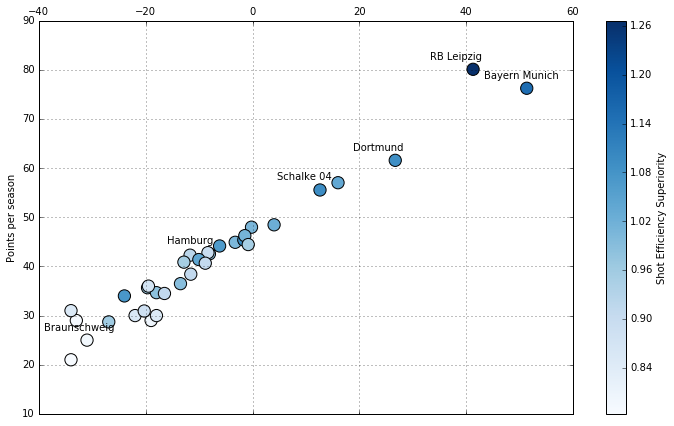

In [767]:
ax = factors_df.plot(kind='scatter', x='GD', y='Points', s=150, c='Ratio_Mean', colormap='Blues', figsize=(10,6), grid=True)

plt.xlabel('Avg. goal differential')
plt.ylabel('Points per season')


ax.tick_params(labelbottom='off',labeltop='on')
ax.xaxis.set_label_position('top') 
plt.tight_layout()

for i in [0,1, 12, 29, 5,33]:
    ax.annotate(factors_df.index[i], (-8+factors_df.ix[i, 'GD'], 2+ factors_df.ix[i, 'Points']))

# Grab colorbar object    
cax = plt.gcf().get_axes()[1]
cax.set_ylabel('Shot Efficiency Superiority')

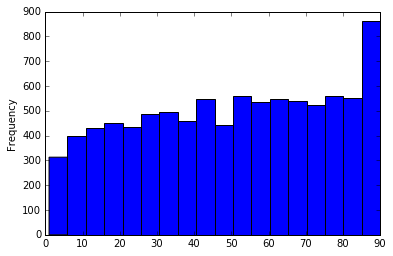

In [759]:
goals_df.loc[:, 'Minute'].plot('hist', bins=18)

In [688]:
complete_running_df.to_csv('Full_Data_2006_2016.csv')

In [777]:
complete_running_df.set_index(['Season', 'Gameday', 'Link']).loc[:, 'FTGD'].apply(np.sign).sort_index().head()

Season  Gameday  Link
2006    1        0      -1.0
                 1       0.0
                 2       1.0
                 3       1.0
                 4       0.0
Name: FTGD, dtype: float64

In [779]:
goals_df = goals_df.set_index(['Season', 'Gameday', 'Link'])

In [ ]:
# complete_df.plot(kind='scatter', x='HGA', y='FTGD')
# complete_df.plot(kind='scatter', x='AGA', y='FTGD')
# complete_running_df.plot.hexbin(x='HGA', y='AGA', gridsize=20)
# complete_running_df.plot.hexbin(x='HGA', y='AGA', C='Odds', gridsize=20)

In [ ]:
# complete_running_df.loc[:, ['Season', 'HGA', 'AGA']].groupby('Season').mean().plot()
# complete_running_df.loc[:, ['Season', 'FTGD', 'HTGD']].groupby('Season').mean().plot()
# (complete_running_df.loc[:, ['Season', 'FTGD', 'HTGD']].groupby('Season').std()*(1,np.sqrt(2.))).plot()

# complete_df.plot.hexbin(x='Odds', y='FTGD', gridsize=15)

In [769]:
goals_merged_df = goals_df.merge(key_df, left_on='TeamH', right_on='KID').merge(key_df, left_on='TeamA', right_on='KID', suffixes=('_H', '_A'))
goals_merged_df = goals_merged_df.drop(['KID_H', 'KID_A', 'TName_H', 'TName_A', 'HGA', 'AGA', 'GradesH', 'GradesA', 'TID_A'], axis=1).set_index('Link').sort_index()

goals_merged_df

KeyError: 'TeamH'

In [ ]:
# matches_df.drop('Headline', axis=1).to_csv("Matches_2006_2016.csv")
# goals_df.to_csv("Goals_2006_2016.csv")
# lineup_df.to_csv("Lineup_2006_2016.csv")


In [510]:
with open("Headlines_2006_2016.csv", "w") as file:
    for line in matches_df.loc[:, 'Headline'].tolist():
        file.write(line.encode('utf-8') + "\n")

AttributeError: 'float' object has no attribute 'encode'

In [ ]:
# #Working code to read data from Kicker files
# from os import listdir

# matches_columns = ['Season', 'Gameday', 'Link', 'TeamH', 'TeamA',
#                    'GoalsH', 'CornersH', 'ChancesH',
#                    'GoalsA', 'CornersA', 'ChancesA', 
#                    'HGA', 'GradesH', 'AGA', 'GradesA', 'Attendance', 'Headline']
# #matches_df = pd.DataFrame(data=None, columns=matches_columns)

# # Table for goal information, can be linked through "Link" with game info
# goals_columns = ['Season', 'Gameday', 'Link', 'Score', 'Minute', 'Player']
# #goals_df = pd.DataFrame(data=None, columns=goals_columns)

# # Table for Starting 11
# lineup_columns = ["Link"] + ["Home_Player" + ("0" + str(i))[-2:] for i in range(1,12)] + ["Away_Player" + ("0" + str(i))[-2:] for i in range(1,12)]
# #lineup_df = pd.DataFrame(data=None, columns=lineup_columns)

# i = 0 

# for filename in listdir("./game_reports/"):
#     if str(filename)[0] != "2":
#         continue
#     try:
#         game_soup = BeautifulSoup(open("./game_reports/" + filename))
#     except:
#         print "Print file not found"
#         continue
    
#     game_info = str(filename).split("_")[0:3]
#     season = int(game_info[0])
#     gameday = int(game_info[1])
#     teams = game_info[2].split("-")
#     teams = map(int, [teams[0], teams[2]])

    
#     game_id = i
#     i += 1
    
#     error_count = 0
#     # Download lineups
#     try:
#         game_soup.find('table', {'class': 'tStat', 'summary': 'Vereinsliste'}).find_all('div', {'class': 'aufstellung_team'})
#         game_soup.find('table', {'class': 'tStat', 'summary': 'Tore & Karten'}).find('div', {'class': 'tore_karten'}).find_all('div', {'class': 'kompletteZeile'})
#         game_soup.find('div', {'class': 'sppinfo'}).find_all('div', id=['ctl00_PlaceHolderHalf_ctl03_kickerDaten', 'ctl00_PlaceHolderHalf_ctl04_kickerDaten'])
#     except:
#         while error_count < 3:
#             try:
#                 print "Reading error. Trying to open from URL."
#                 url = game_soup.find('meta', {'property': 'og:url'})
#                 url = url.attrs['content'] 
#                 file = requests.get(url)
#                 game_soup = BeautifulSoup(file.content, 'lxml')
#                 filename = str(season) + "_"
#                 filename += ("0" + str(gameday))[-2:] + "_" 
#                 filename += str(teams[0]) + "-v-" + str(teams[1])
                    
#                 with open("game_reports/" + filename + "_main.html", 'w') as file:
#                     file.write(game_soup.encode('ISO-8859-1'))
#                 print "Success opening from URL. File downloaded."    
#                 break
#             except:
#                 error_count += 1

                
#     headline = game_soup.find('meta', {'property': 'og:title'}).attrs['content'] 
        
#     team1_stats = [int(headline[-9])]
#     team2_stats = [int(headline[-7])]
    
#     headline = headline.split(":")[0]
    
        
#     if error_count < 3:
#         both_teams = game_soup.find('table', {'class': 'tStat', 'summary': 'Vereinsliste'})
#         lineup = []
#         for one_team in both_teams.find_all('div', {'class': 'aufstellung_team'}):
#             for player in one_team.find_all('a', {'class': 'link_noicon'}):
#                 lineup.append(player.get('href').split("/")[8])
#                 # Make sure to only download the first 11, the Starting 11, for each team
#                 if np.mod(len(lineup), 11) == 0:
#                     break
#         lineup = [game_id] + map(int, lineup)
#     else:
#         print "Error in reading and opening for " + game_soup.find('title').text
#         lineup = [game_id] + [np.nan for _ in range(22)]

#     lineup_df = lineup_df.append(pd.DataFrame(data=[lineup], columns=lineup_columns), ignore_index=True)

    
#     # For whatever reason, number of chances is stored in a different table. Grab this and add to list.     
#     #sppinfo = game_soup.find('div', {'class': 'sppinfo'})
#     for value in game_soup.find_all('div', id=['ctl00_PlaceHolderHalf_ctl03_kickerDaten', 'ctl00_PlaceHolderHalf_ctl04_kickerDaten']):
#         corners = value.find('div', {'class': 'ecken'}).findNext('div').text.split(':')
#         team1_stats.append(int(corners[0]))
#         team2_stats.append(int(corners[1]))
#         chances = value.find('div', {'class': 'chancen'}).findNext('div').text.split(':')
#         team1_stats.append(int(chances[0]))
#         team2_stats.append(int(chances[1]))

#     # Download number of people in attendance
#     for value in game_soup.find_all('div', id=['ctl00_PlaceHolderHalf_ctl03_zuschauer', 'ctl00_PlaceHolderHalf_ctl04_zuschauer']):
#         attendance = value.find('div', {'class': 'wert'}).text
#         if attendance.find('(') > 0:
#             # "Error" handling if stadion is sold out
#             attendance = attendance[0:attendance.find('(')]
#         attendance = int(attendance.strip())


#     grade_row = []
#     for lineup in game_soup.find('table', {'class': 'tStat', 'summary': 'Vereinsliste'}).find_all('div', {'class': 'aufstellung_team'}):
#         no_players = 0
#         grade = []
#         for player in lineup.find_all('a'):
#             grade_raw = unicode(player.next_sibling)

#             grade_del1 = unicode(grade_raw).find('(')
#             grade_del2 = unicode(grade_raw).find(')')

#             if grade_del1 == -1:
#                 continue

#             grade += [float(grade_raw[grade_del1+1:grade_del2].replace(",", "."))]

#             no_players += 1
#             if no_players == 11:
#                 break
#         grade_mean = np.sum(grade)/no_players

#         grade_row += [grade_mean, grade]

#     # Write stats for game into dataframe

#     feed = [season] + [gameday] + [game_id] + teams + team1_stats + team2_stats + grade_row + [attendance] + [headline]
#     feed += [np.nan] * (len(matches_columns) - len(feed))
#     matches_df = matches_df.append(pd.DataFrame(data=[feed], columns=matches_columns), ignore_index=True)

#     # Find the scorers in the game and download the info
#     goal_list = []
#     goals_cards = game_soup.find('table', {'class': 'tStat', 'summary': 'Tore & Karten'})
#     try:
#         goals = goals_cards.find('div', {'class': 'tore_karten'}).find_all('div', {'class': 'kompletteZeile'})
#     except:
#         goal_list.append([season, gameday, game_id, np.nan, np.nan, np.nan])
#         goals_df = goals_df.append(pd.DataFrame(data=goal_list, columns=goals_columns), ignore_index=True)
#         continue

#     for goal in goals:
#         goal_text = goal.text
#         goal_link = goal.find('a')
#         player = goal_link.get('href').split("/")[8]

#         pos = goal_text.find(":")
#         score = int(goal_text[pos-1:pos])-int(goal_text[pos+1:pos+2])
#         pos = goal_text.find(".,")
#         # "Error" handling for when a goal is scored in overtime. Treat as 45' and 90'.
#         if pos < 0:
#             pos = goal_text.find(". +") 
#         minute = goal_text[0:pos]
#         pos = minute.find("(")
#         minute = int(minute[pos+1:])

#         goal_list.append([season, gameday, game_id, score, minute, player])
    
#     # If goals fell, write info into goal dataframe.    
#     if len(goal_list) > 0:
#         goals_df = goals_df.append(pd.DataFrame(data=goal_list, columns=goals_columns), ignore_index=True)

In [455]:
# # Working Code to Download all Game Reports from Kicker

# for year in range(2016, 2017):
#     for gameday in range(14,15):
#         print year, gameday
#         url = "http://www.kicker.de/news/fussball/bundesliga/spieltag/1-bundesliga/"
#         url = url + str(year) + "-" + str(year+1)[2:4] + "/"
#         url = url + str(gameday) + "/0/spieltag.html"

#         website = requests.get(url)
#         main = BeautifulSoup(website.content, 'html.parser')
#         main_table = main.find('table', {'class': 'tStat', 'summary': 'Tabelle'})

#         # Once we get to the unplayed gamedays, no table will be displayed, and the loop shall end.
#         try:
#             main_standings = main_table.find_all('a', {'class': 'link verinsLinkBild'})
#         except:
#             break
            
#         main_matches = main.find('table', {'class': 'tStat tab1-bundesliga', 'summary': 'Begegnungen'})

#         # Find all links of class "link." These refer to the game analyses.
#         for game in main_matches.find_all('a', {'class' : 'link'}):
#             # result = game.parent.previous_sibling.previous_sibling.text
#             # result = map(int, result[0:result.find("(")-1].split(":"))

#             game_url = game.get('href')
#             encoded_in_url = game_url.split("/")

#             # Game ID is the article ID for kicker, as unique ID for game
#             game_id = encoded_in_url[8][0:7]

#             # Game URL encodes the teams which are playing
#             teams = encoded_in_url[9][13:-5].split("_")
#             teams = map(int, [teams[i][teams[i].rfind('-')+1:] for i in range(2)])

#             # URL to open individiual games
#             game_url = "http://www.kicker.de" + game_url

#             error_count = 0
#             while error_count < 3:
#                 try:
#                     game_file = requests.get(game_url)
#                     game_soup = BeautifulSoup(game_file.content, 'html.parser')
#                     filename = str(year) + "_"
#                     filename += ("0" + str(gameday))[-2:] + "_" 
#                     filename += str(teams[0]) + "-v-" + str(teams[1])
                    
#                     with open("game_reports/" + filename + "_main.html", 'w') as file:
#                         file.write(game_soup.encode('ISO-8859-1'))
#                         break
#                 except:
#                     error_count += 1

#             if error_count == 3:
#                 continue

2016 14
